The examples below assume that we have installed the package _genephys_ from PyPi. The examples follow the experiments from <a href="https://www.biorxiv.org/content/10.1101/2023.01.03.522583v2.abstract" > Vidaurre (2023)</a>, where the mathematical specification of the model can be found. 

In all the examples, we will be generating data with _N_=250 trials, _T_=400 time points per trial and _nchan_=64 channels. Frequency here refers to angular frequency; to obtain the ordinary frequency we just need to multiply by $\frac{F}{2 \pi}$, where $F$ is the sampling frequency in Hz. 

We first generate some spontaneous activity, with time-varying frequency in the range [0.15, 0.15 $\pi$] and time-varying amplitude in the range [0.8,1.2]. Here, amplitude is just a multiplying factor on the signal; for example, a sinusoid taking values in [-1,1], when multiplied by an amplitude factor of 2.0, would take values in [-2,2]. 

In [1]:
# Basic imports and variable setting
from genephys import sampler,decoders,graphics
import math
import numpy as np

N,T,nchan = 250,250,32
Q = 2 # two classes

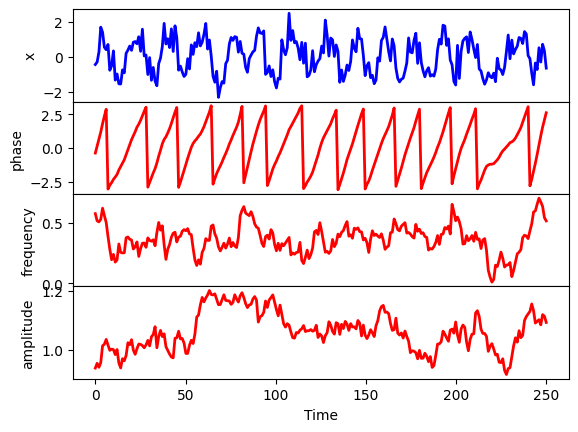

In [2]:
# evoked_options_empty contains the parameters regarding stimulation;
# we set all the types of effect to False since this is spontaneous activity under no stimulation
evoked_options_empty = {"phase_reset": False, "amplitude_modulation": False, 
    "additive_response": False, "additive_oscillation": False}
# spont_options contains the parameters regarding spontaneous activity; 
# we just specify the ranges of angular frequency and amplitude 
spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

# We create the DataSampler object; 
# the third parameter is the number of types of stimuli; we specify None 
ds_rest = sampler.DataSampler(T,nchan,None,spont_options,evoked_options_empty)

# We sample N "trials"
(X,Phase,Freq,Amplitude,_,_,_) = ds_rest.sample(N)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,None,0,0)

As a sanity check, we separately generate a stimulus time series and try to decode it from the spontaneous signal. As it should be, decoding accuracy fluctuates randomly around baseline. 


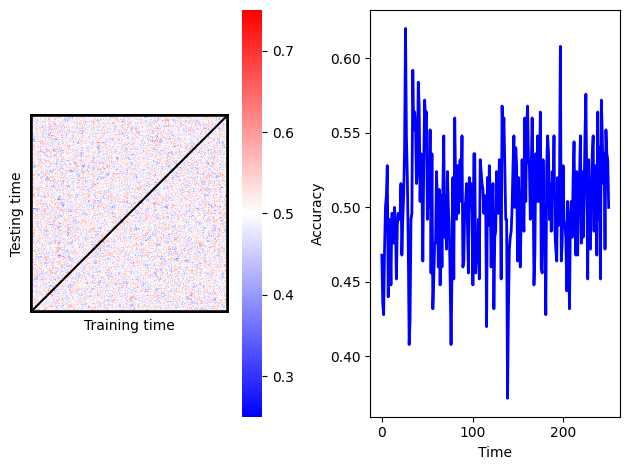

In [3]:
Stim = ds_rest.sample_stimulus(N,2,T)
decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)
graphics.plot_accuracy(accuracy)

Now, let's generate data where a two-class stimulation is presented. Here, we have a phase-resetting effect on two relevant channels, while the others don't respond. These two channels reset to stimulus-specific phase $\psi^k$ in a quite consistent manner (i.e. they have some phase noise that is sampled from a von Mises distribution with low standard deviation $\sigma_{\psi}$)


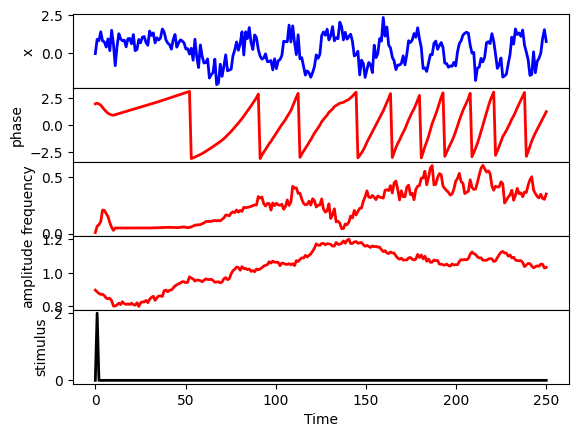

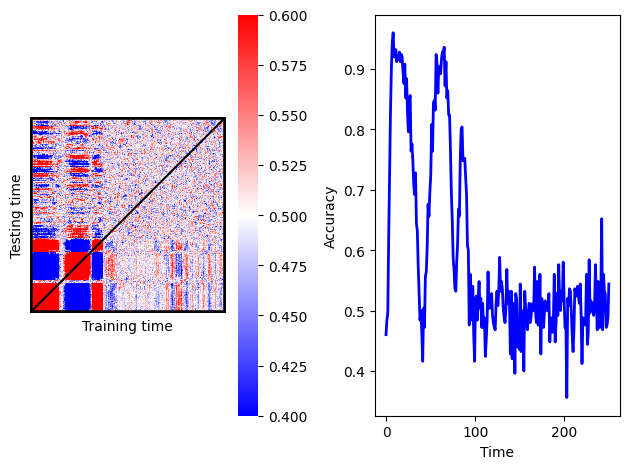

In [4]:
# Channel probability is 0.0 except for the first channel, where it is 1.0
chan_prob = np.zeros(nchan)
chan_prob[0] = 1.0 

# mean phase effect (this is the default)
PH = np.zeros((Q,nchan))
PH[0,:] = -math.pi/2
PH[1,:] = +math.pi/2
# Standard deviation for the phase distribution 
std_ph = 0.15 * math.pi

# latency of response 
DELAY = np.zeros((Q,nchan))
DELAY[0,:] = np.linspace(0,40,nchan) # 5 60
DELAY[1,:] = DELAY[0,:]
DELAY_JITTER = 0

# frequencies of entrainent
ENTRAINMENT_STRENGTH = 0.5  
F_ENTRAINMENT = np.linspace(0.5,1.5,nchan) * 0.2
np.random.shuffle(F_ENTRAINMENT)
F_ENTRAINMENT = F_ENTRAINMENT

# activation function
KERNEL_TYPE_PH = ('Log','Log')
KERNEL_PAR_PH = ((2,10,0),(4,100,0),0) # (5,(2,160,0),0)

# non-oscillatory response
ADDR = np.zeros((Q,nchan))
ADDR[0,:] = -0.35
ADDR[1,:] = 0.35
STD_ADDR = 0.15

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False,
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "PH": PH, "STD_PH": std_ph,
    "DELAY_JITTER": DELAY_JITTER,
    "DELAY": DELAY,  
    "F_ENTRAINMENT": F_ENTRAINMENT, "ENTRAINMENT_STRENGTH": ENTRAINMENT_STRENGTH,
    "KERNEL_TYPE_PH": KERNEL_TYPE_PH,
    "KERNEL_PAR_PH": KERNEL_PAR_PH,
    "ADDR": ADDR, "STD_ADDR": STD_ADDR,
    "KERNEL_TYPE_ADDR": ('Log','Log'),
    "KERNEL_PAR_ADDR": ((3,50,0),(3,150,0),0),    
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
Stimulus = ds_task.sample_stimulus(N,Q,T,t=1) 
(X,Phase,Freq,Amplitude,_,_,Stim) = ds_task.sample(N,Stimulus=Stimulus)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,2,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.4,0.6))

As we see, while the diagonal of the TGM is plausible, the TGM itself has a chequered pattern we don't see in real data. In contrast, as we see below, making channel responses stochastic (by setting a probability of responding per channel of $\theta=1/6$), produces much more realistic results. We also accompany the effect with a non-oscillatory component, which, as shown in the paper, is important to generate realistic-looking results.

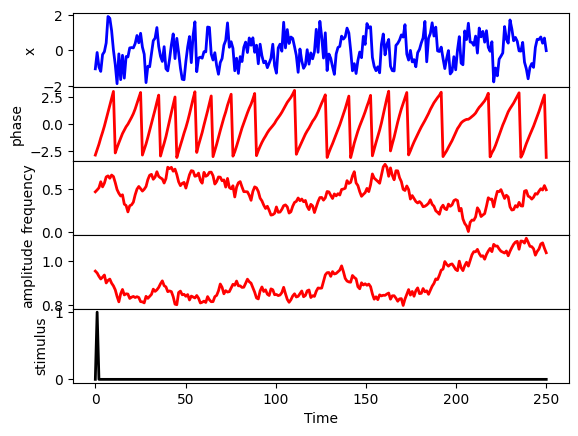

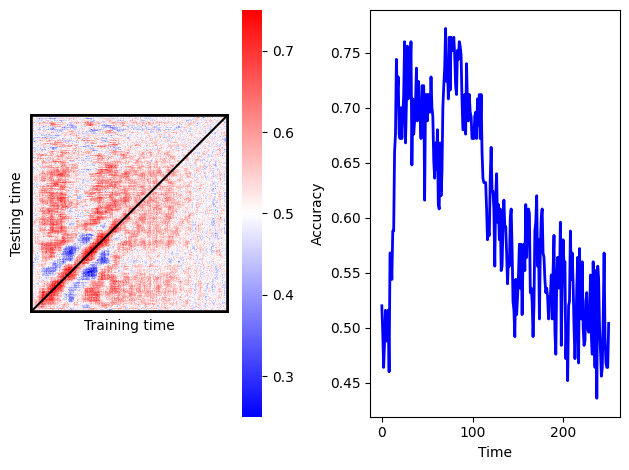

In [5]:
# Channel probability is 1/8 for half of the channels, the rest are irrelevant
chan_prob = (1/6) * np.ones((nchan,))

# mean phase effect (this is the default)
PH = np.zeros((Q,nchan))
PH[0,:] = -math.pi/2
PH[1,:] = +math.pi/2
# Standard deviation for the phase distribution 
std_ph = 0.15 * math.pi

# latency of response 
DELAY = np.zeros((Q,nchan))
DELAY[0,:] = np.linspace(0,40,nchan) 
DELAY[1,:] = DELAY[0,:]
DELAY_JITTER = 0

# frequencies of entrainent
ENTRAINMENT_STRENGTH = 0.5  
F_ENTRAINMENT = np.linspace(0.5,1.5,nchan) * 0.2
np.random.shuffle(F_ENTRAINMENT)
F_ENTRAINMENT = F_ENTRAINMENT

# activation function
KERNEL_TYPE_PH = ('Log','Log')
KERNEL_PAR_PH = ((2,10,0),(4,100,0),0) 

# non-oscillatory response
ADDR = np.zeros((Q,nchan))
ADDR[0,:] = -0.35
ADDR[1,:] = 0.35
STD_ADDR = 0.15

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False,
    "additive_response": True, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "PH": PH, "STD_PH": std_ph,
    "DELAY": DELAY, "DELAY_JITTER": DELAY_JITTER, 
    "F_ENTRAINMENT": F_ENTRAINMENT, 
    "ENTRAINMENT_STRENGTH": ENTRAINMENT_STRENGTH,
    "KERNEL_TYPE_PH": KERNEL_TYPE_PH,
    "KERNEL_PAR_PH": KERNEL_PAR_PH,
    "ADDR": ADDR, "STD_ADDR": STD_ADDR,
    "KERNEL_TYPE_ADDR": ('Log','Log'),
    "KERNEL_PAR_ADDR": ((3,50,0),(3,150,0),0)    
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
Stimulus = ds_task.sample_stimulus(N,Q,T,t=1) 
(X,Phase,Freq,Amplitude,_,_,Stim) = ds_task.sample(N,Stimulus=Stimulus)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,0,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.25,0.75))

We now simulate another type of oscillatory effect, an additive oscillatory component. We will also add a non-oscillatory component. We will use a diversity of response latencies (parameter _DELAY_; in the math specification of the model corresponding to $\delta_1$) and a diversity of frequencies across channels (parameter _ADDOA_; in the math specification, $\omega^k$). Together with an appropriate choice of the response kernel function (_KERNEL\_PAR_), this setup  produces quite realistic TGMs.


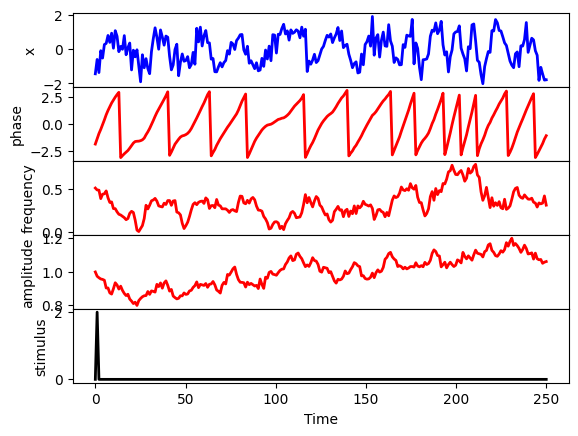

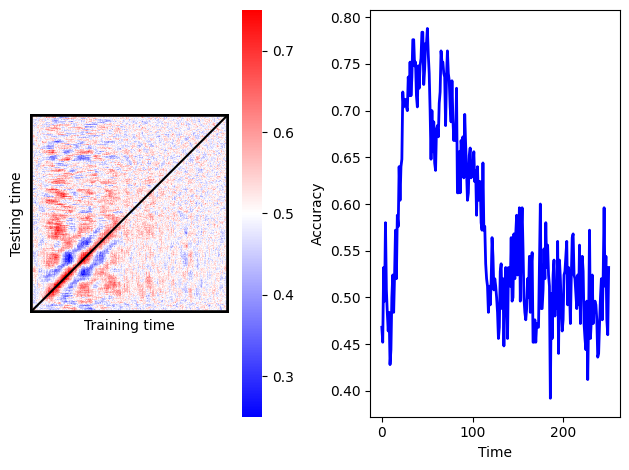

In [6]:
# Channel probability 
chan_prob = np.zeros((nchan,))
chan_prob[0:nchan] = 1/6

# latency of response 
DELAY = np.zeros((Q,nchan))
DELAY[0,:] = np.linspace(0,30,nchan) # 5,60
DELAY[1,:] = DELAY[0,:]
DELAY_JITTER = 0 # jitter of the latency

# parameters of the additive oscillatory response (per class)
# amplitude
ADDOA = 2 * np.ones((Q,nchan)) 
# frequency
f = np.linspace(0.5,1,nchan) * 0.2 # 0.2 * np.linspace(0.75,0.95,nchan)
np.random.shuffle(f)
ADDOF = np.zeros((Q,nchan))
ADDOF[0,:] = f
ADDOF[1,:] = f
# phase
ADDOP = np.zeros((Q,nchan))
ADDOP[0,:] = -10
ADDOP[1,:] = +10
# standard deviations
STD_ADDOF, STD_ADDOA, STD_ADDOP = (0.01,0.01,0.01)
 
# activation function
KERNEL_TYPE_ADDO = ('Log','Log')
KERNEL_PAR_ADDO = ((2,10,0),(4,100,0),0) # (5,(2,160,0),0)

# parameters of the non-oscillator response
ADDR = np.zeros((Q,nchan))
ADDR[0,:] = -0.25
ADDR[1,:] = 0.25
STD_ADDR = 0.5

# options for spontaneous activity 
spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}  # 0.01-0.75 vs 0.1-0.2

evoked_options = {"phase_reset": False, "amplitude_modulation": False,
    "additive_response": True, "additive_oscillation": True,
    "CHAN_PROB": chan_prob,
    "DELAY_JITTER": DELAY_JITTER,
    "DELAY": DELAY,
    "KERNEL_TYPE_ADDR": ('Log','Log'),
    "KERNEL_PAR_ADDR": ((3,25,0),(3,150,0),0), #((3,50,0),(3,150,0),0)
    "ADDR": ADDR, "STD_ADDR": STD_ADDR,
    "KERNEL_TYPE_ADDO": KERNEL_TYPE_ADDO,
    "KERNEL_PAR_ADDO": KERNEL_PAR_ADDO,
    "ADDOA": ADDOA, "ADDOP": ADDOP, "ADDOF": ADDOF,
    "STD_ADDOF": STD_ADDOF, "STD_ADDOA": STD_ADDOA, "STD_ADDOP": STD_ADDOP,
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
Stimulus = ds_task.sample_stimulus(N,Q,T,t=1) 
(X,Phase,Freq,Amplitude,_,_,Stim) = ds_task.sample(N,Stimulus=Stimulus)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,0,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.25,0.75))

We will now assess the effect of an amplitude enhancement of additive oscillatory component. We will use double the increase of amplitude than in the previous cell.

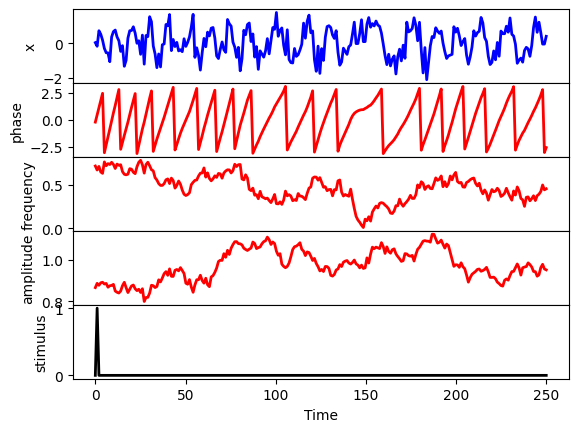

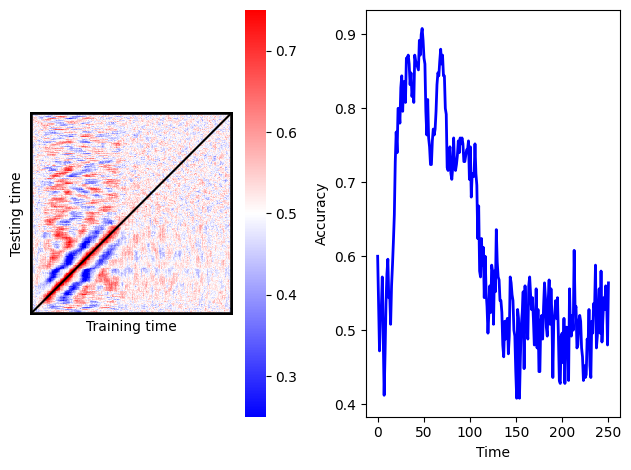

In [7]:
ADDOA = 5 * np.ones((Q,nchan)) # amplitude
evoked_options["ADDOA"] = ADDOA

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
Stimulus = ds_task.sample_stimulus(N,Q,T,t=1) 
(X,Phase,Freq,Amplitude,_,_,Stim) = ds_task.sample(N,Stimulus=Stimulus)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,0,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.25,0.75))

We will now test the effect of an additive, non-oscillatory response on top of the phase reset. We will double the effect from the previous cell.  

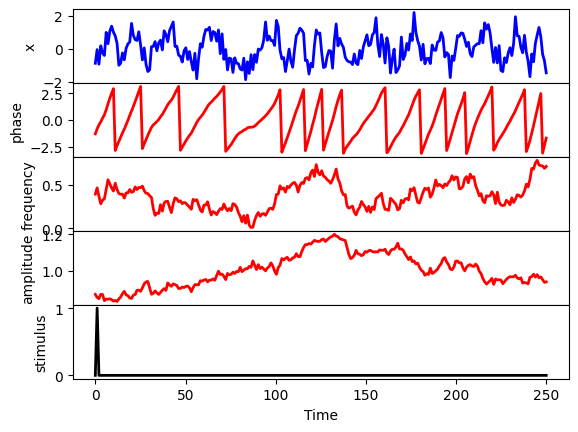

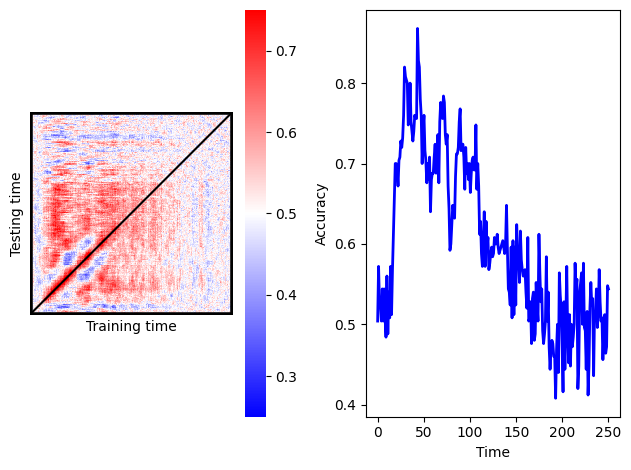

In [8]:
ADDOA = 2 * np.ones((Q,nchan)) # like before

ADDR = np.zeros((Q,nchan))
ADDR[0,:] = -0.5
ADDR[1,:] = 0.5
STD_ADDR = 0.5

evoked_options["ADDOA"] = ADDOA
evoked_options["ADDR"] = ADDR
evoked_options["STD_ADDR"] = STD_ADDR

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
Stimulus = ds_task.sample_stimulus(N,Q,T,t=1) 
(X,Phase,Freq,Amplitude,_,_,Stim) = ds_task.sample(N,Stimulus=Stimulus)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,0,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.25,0.75))